# GFD-Poisson
Generalized Finite Differences Methods for numerically solve Poisson Equation on highly irregular regions.

Below are examples of the implementation of a Generalized Finite Difference Method to compute an approximation to the solution of the Poisson equation in 2D.

The problem to solve is
\begin{equation}
     \frac{\partial^2}{\partial x^2} \phi(x,y) + \frac{\partial^2}{\partial y^2} \phi(x,y) = -f(x,y)
\end{equation}

where $\phi(x,y)$ is the function to be approximated.

## Logically Rectangular Meshes

Due to advances in the numerical generation of structured meshes, it is possible to mesh highly irregular regions.

For example, the CUI region (standing for Cuitzeo Lake),

<center><img src="/Notebook_Figures/fig01.png" alt="Cuitzeo Lake region" width="240" height="240"/></center>

can be meshed as

<center><img src="/Notebook_Figures/fig02.png" alt="Cuitzeo mesh" width="240" height="240"/></center>

One of the greatest advantages of structured grides is that it is possible to take advantage of the data structure to make numerical approximations over them.

### Python Modules Importation
The first thing that we have to do is to import all the Python modules that will be used for the approximation. In the following code, we import the Modules:
- scipy.io.loadmat: In order to import data from Matlab files.
- numpy: In order to be able to use numerical computing.
- matplotlib.pyplot: In order to be able to graph the results.
- matplotlib.cm: To use different colormaps for the graphics.

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

### Getting the region data
Now, it is required to have all the data of the region loaded into Python variables.

In [2]:
mat  = loadmat('Data/Meshes/CUI81.mat')                                         # The data is loaded form a .mat file.
x  = mat['x']                                                                   # The x-coordinates are saved in x.
y  = mat['y']                                                                   # The y-coordinates are saved in y.

### Variable Initialization
In order to correctly compute the approximation, some variables are required to be initialized.

In [3]:
me    = x.shape                                                                 # The size of the mesh is found.
m     = me[0]                                                                   # The number of nodes in x.
n     = me[1]                                                                   # The number of nodes in y.
err   = 1                                                                       # err initialization in 1.
iter  = 0                                                                       # Number of iterations.
tol   = 1e-8                                                                    # The tolerance is defined.
m_it  = 10000                                                                   # Maximum number of iterations (this will depend on the size of the mesh and the tolerance).
u_ap  = np.zeros([m,n])                                                         # u_ap initialization with zeros.
u_ex  = np.zeros([m,n])                                                         # u_ex initialization with zeros.
Gamma = np.zeros([m,n,9])                                                       # Gamma initialization with zeros.

### Boundary conditions
The boundary conditions must be defined. For this example, we will define the condition as:

\begin{equation}
    \phi = 2e^{2x+y}
\end{equation}

In [4]:
def phi(x,y):                                                                   # Definition of the Phi function.
    fun = 2*np.exp(2*x+y)                                                       # Phi condition.
    return fun                                                                  # Return phi.

for i in range(m):                                                              # For each of the nodes on the x boundaries.
    u_ap[i, 0]   = phi(x[i, 0],   y[i, 0])                                      # The boundary condition is assigned at the first y.
    u_ap[i, n-1] = phi(x[i, n-1], y[i, n-1])                                    # The boundary condition is assigned at the last y.
for j in range(n):                                                              # For each of the nodes on the y boundaries.
    u_ap[0,   j] = phi(x[0,   j], y[0,   j])                                    # The boundary condition is assigned at the first x.
    u_ap[m-1, j] = phi(x[m-1, j], y[m-1, j])                                    # The boundary condition is assigned at the last x.

### Gammas
The Gammas are the "weights" that will be used in order to have a a Finite Difference-based approximation.

In [5]:
L = np.vstack([[0], [0], [2], [0], [2]])                                        # The values of the differential operator are assigned.

for i in range(1,m-1):                                                          # For each of the nodes in x.
    for j in range(1,n-1):                                                      # For each of the nodes in y.
        dx = np.array([x[i + 1, j]   - x[i, j], x[i + 1, j + 1] - x[i, j], \
                       x[i, j + 1]   - x[i, j], x[i - 1, j + 1] - x[i, j], \
                       x[i - 1, j]   - x[i, j], x[i - 1, j - 1] - x[i, j], \
                       x[i, j - 1]   - x[i, j], x[i + 1, j - 1] - x[i, j]])     # dx is computed.
            
        dy = np.array([y[i + 1, j]   - y[i, j], y[i + 1, j + 1] - y[i, j], \
                       y[i, j + 1]   - y[i, j], y[i - 1, j + 1] - y[i, j], \
                       y[i - 1, j]   - y[i, j], y[i - 1, j - 1] - y[i, j], \
                       y[i, j - 1]   - y[i, j], y[i + 1, j - 1] - y[i, j]])     # dy is computed.
            
        M = np.vstack([[dx], [dy], [dx**2], [dx*dy], [dy**2]])                  # M matrix is assembled.
        M = np.linalg.pinv(M)                                                   # The pseudoinverse of matrix M.
        YY = M@L                                                                # M*L computation.
        Gem = np.vstack([-sum(YY), YY])                                         # Gamma values are found.
        for k in range(9):                                                      # For each of the Gamma values.
            Gamma[i,j,k] = Gem[k]  

### Generalized Finite Differences Method
With the computed Gammas, it is possible to apply a Finite Difference Method in order to get an approximation.

It is required to have the "right-hand-size" of Poisson equation, for this case, this will be defined as:
\begin{equation}
    f = 10e^{2x+y}
\end{equation}

In [6]:
def f(x,y):                                                                     # Definition of the f function.
    fun = 10*np.exp(2*x+y)                                                      # f condition.
    return fun                                                                  # Return f.

while err >= tol and iter <= m_it:                                              # Check for iterations and tolerance.
    err = 0                                                                     # Error becomes zero to be able to update.
    for i in range(1,m-1):                                                      # For each of the nodes on the x axis.
        for j in range(1,n-1):                                                  # For each of the nodes on the y axis.
            t = (f(x[i, j], y[i, j]) - (            \
                Gamma[i, j, 1]*u_ap[i + 1, j    ] + \
                Gamma[i, j, 2]*u_ap[i + 1, j + 1] + \
                Gamma[i, j, 3]*u_ap[i    , j + 1] + \
                Gamma[i, j, 4]*u_ap[i - 1, j + 1] + \
                Gamma[i, j, 5]*u_ap[i - 1, j    ] + \
                Gamma[i, j, 6]*u_ap[i - 1, j - 1] + \
                Gamma[i, j, 7]*u_ap[i    , j - 1] + \
                Gamma[i, j, 8]*u_ap[i + 1, j - 1]))/Gamma[i, j, 0]              # u_ap is calculated at the central node.
            err = max(err, abs(t - u_ap[i, j]));                                # Error computation.
            u_ap[i,j] = t;                                                      # The previously computed value is assigned.
    iter += 1 

###

### Theoretical Solution
For this example, the theoretical solution can be computed as the boundary condition, and it will be computed in order to have a point of comparison for the computed numerical solution.

In [7]:
for i in range(m):                                                              # For all the nodes on x.
    for j in range(n):                                                          # For all the nodes on y.
        u_ex[i,j] = phi(x[i,j], y[i,j])                                         # The theoretical solution is computed.

### Error
The error can be computed as the mean square error given by
\begin{equation}
    \mid e \mid^2 = \left(\sqrt{\sum_{i,j} (u_{i,j} - U_{i,j})}\right) A_{i,j}
\end{equation}

where $u_{i,j},j$ and $U_{i,j}$ are the computed and theoretical solution, respectively, and $A_{i,j}$ is the area of the corresponding polygon given by the neighbor nodes.

In [8]:
def PolyArea(x,y):
    area = 0.5*np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))      # Area of the polygon given by the x and y coordinates.
    return area

In [9]:
err   = 0                                                                       # err initialization with 0.
area = np.zeros([m,n])                                                          # area initialization with zeros.

for i in np.arange(1,m-1):                                                      # For each of the nodes on the x axis.
    for j in np.arange(1,n-1):                                                  # For each of the nodes on the y axis.
        px = np.array([x[i+1, j], x[i+1, j+1], x[i, j+1], x[i-1, j+1], \
                       x[i-1, j], x[i-1, j-1], x[i, j-1], x[i+1, j-1]])         # The x-values of the polygon are stored.
        py = np.array([y[i+1, j], y[i+1, j+1], y[i, j+1], y[i-1, j+1], \
                       y[i-1, j], y[i-1, j-1], y[i, j-1], y[i+1, j-1]])         # The y-values of the polygon are stored.
        area[i,j] = PolyArea(px,py)                                             # Area computation.

for i in np.arange(m):                                                          # For each of the nodes on the x axis.
    for j in np.arange(n):                                                      # For each of the nodes on the y axis.
        err = err + area[i,j]*(u_ap[i,j] - u_ex[i,j])**2                        # Mean error computation.
    
err = np.sqrt(err)                                                              # The mean square error.

print('The mean square error in the mesh is: ', err)

The mean square error in the mesh is:  0.0001679665549620578


### Graphics
It is possible to graph the computed solution along with the theoretical solution to get a graphical idea on how good the approximation is.

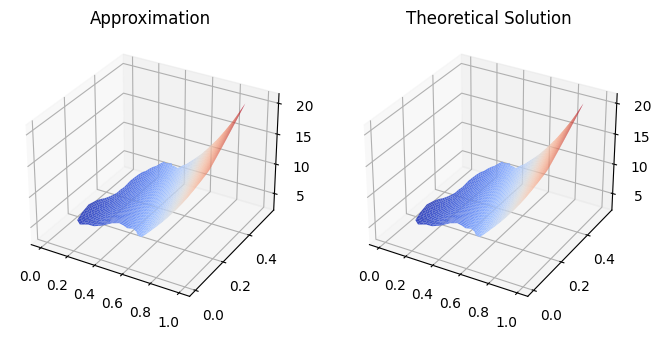

In [10]:
mini = u_ex.min()                                                               # The minimum value of the theoretical solution for axis.
maxi = u_ex.max()                                                               # The maximum value of the theoretical solution for axis.
    
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, \
                                                 figsize=(8, 4))                # A figure is created.
    
ax1.set_title('Approximation')                                                  # The subtitle for the approximation.
ax1.set_zlim([mini, maxi])                                                      # Axis for the approximation.
ax1.plot_surface(x, y, u_ap, cmap=cm.coolwarm)                                  # Graphic of the approximation.
    
ax2.set_title('Theoretical Solution')                                           # The subtitle for the theoretical solution.
ax2.set_zlim([mini, maxi])                                                      # Axis for the theoretical solution.
ax2.plot_surface(x, y, u_ex, cmap=cm.coolwarm)                                  # Graphic of the theoretical solution.

plt.show()                                                                      # Show the plot.

## Triangulations

Triangulations for highly irregular regions are easy to obtain, and the Generalized Finite Differences Method can be easily adapted in order to work with this data structure. 

As an example, one more time, the CUI region,

<center><img src="/Notebook_Figures/fig01.png" alt="Cuitzeo Lake region" width="240" height="240"/></center>

can be meshed with triangulations as

<center><img src="/Notebook_Figures/fig03.png" alt="Cuitzeo mesh" width="240" height="240"/></center>

The main "problem" od these triangulations is to use non-structured points as data.

### Python Modules Importation
The first thing that we have to do is to import all the Python modules that will be used for the approximation. In the following code, we import the Modules:
- scipy.io.loadmat: In order to import data from Matlab files.
- numpy: In order to be able to use numerical computing.
- matplotlib.pyplot: In order to be able to graph the results.
- matplotlib.cm: To use different colormaps for the graphics.

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

### Getting the region data
Now, it is required to have all the data of the region loaded into Python variables.

In [2]:
mat  = loadmat('Data/Clouds/CUI_1.mat')                                         # The data is loaded form a .mat file.
p   = mat['p']                                                                  # The coordinates of the nodes are saved in p.
pb  = mat['pb']                                                                 # The coordinates of the boundary are saved un pb.
tt  = mat['t']                                                                  # The triangulations are saved in tt.
if tt.min() == 1:                                                               # For Delaunay triangulations made in Matlab.
    tt -= 1                                                                     # Subtract 1 from all the indexes.

### Variable Initialization
In order to correctly compute the approximation, some variables are required to be initialized.

In [3]:
m    = len(p[:,0])                                                              # The total number of nodes is calculated.
mf   = len(pb[:,0])                                                             # The number of boundary nodes is calculated.
nvec = 8                                                                        # The maximum number of nodes.
err  = 1                                                                        # err initialization in 1.
iter = 0                                                                        # Number of iterations.
tol   = 1e-8                                                                    # The tolerance is defined.
m_it  = 10000                                                                   # Maximum number of iterations (this will depend on the size of the mesh and the tolerance).
u_ap = np.zeros([m])                                                            # u_ap initialization with zeros.
u_ex = np.zeros([m])                                                            # u_ex initialization with zeros.
Gamma = np.zeros([m, nvec+1])                                                   # Gamma initialization with zeros.

### Boundary conditions
The boundary conditions must be defined. For this example, we will define the condition as:

\begin{equation}
    \phi = 2e^{2x+y}
\end{equation}

In [4]:
def phi(x,y):                                                                   # Definition of the Phi function.
    fun = 2*np.exp(2*x+y)                                                       # Phi condition.
    return fun                                                                  # Return phi.

for i in np.arange(mf):                                                         # For each of the boundary nodes.
    u_ap[i]   = phi(pb[i, 0], pb[i, 1])                                         # The boundary condition is assigned.

### Neighbor search
The neighbor nodes are necessary in order to compute an approximation for the solution. In this case, we take advantage of the triangulation structure in order to get the immediate neighbors in the triangles.

In [5]:
vec = np.zeros([m, nvec], dtype=int)-1                                          # The array for the neighbors is initialized.

for i in np.arange(m):                                                          # For each of the nodes.
    kn   = np.argwhere(tt == i)                                                 # Search in which triangles the node appears.
    vec2 = np.setdiff1d(tt[kn[:,0]], i)                                         # Neighbors are stored inside vec2.
    vec2 = np.vstack([vec2])                                                    # Convert vec2 to a column.
    nvec2 = sum(vec2[0,:] != -1)                                                # The number of neighbors of the node is calculated.
    nnvec = np.minimum(nvec, nvec2)
    for j in np.arange(nnvec):                                                  # For each of the nodes.
        vec[i,j] = vec2[0,j]                                                    # Neighbors are saved.

### Gammas
The Gammas are the "weights" that will be used in order to have a a Finite Difference-based approximation.

In [6]:
L = np.vstack([[0], [0], [2], [0], [2]])                                        # The values of the differential operator are assigned.

for i in np.arange(mf, m):                                                      # For each of the inner nodes.
    nvec = sum(vec[i,:] != -1)                                                  # The total number of neighbors of the node.
    dx = np.zeros([nvec])                                                       # dx initialization with zeros.
    dy = np.zeros([nvec])                                                       # dy initialization with zeros.

    for j in np.arange(nvec):                                                   # For each of the neighbor nodes.
        vec1 = int(vec[i, j])                                                   # The neighbor index is found.
        dx[j] = p[vec1, 0] - p[i,0]                                             # dx is computed.
        dy[j] = p[vec1, 1] - p[i,1]                                             # dy is computed.

    M = np.vstack([[dx], [dy], [dx**2], [dx*dy], [dy**2]])                      # M matrix is assembled.
    M = np.linalg.pinv(M)                                                       # The pseudoinverse of matrix M.
    YY = M@L                                                                    # M*L computation.
    Gem = np.vstack([-sum(YY), YY])                                             # Gamma values are found.
    for j in np.arange(nvec+1):                                                 # For each of the Gamma values.
        Gamma[i,j] = Gem[j]                                                   # The Gamma value is stored. 

### Generalized Finite Differences Method
With the computed Gammas, it is possible to apply a Finite Difference Method in order to get an approximation.

It is required to have the "right-hand-size" of Poisson equation, for this case, this will be defined as:
\begin{equation}
    f = 10e^{2x+y}
\end{equation}

In [7]:
def f(x,y):                                                                     # Definition of the f function.
    fun = 10*np.exp(2*x+y)                                                      # f condition.
    return fun                                                                  # Return f.

while err >= tol and iter <= m_it:                                              # Check for iterations and tolerance.
    err = 0                                                                     # Error becomes zero to be able to update.
    for i in np.arange(mf, m):                                                  # For each of the interior nodes.
        utemp = 0                                                               # utemp is initialized with zero.
        nvec = sum(vec[i,:] != -1)                                              # The number of neighbors of the central node.
        for j in np.arange(1,nvec+1):                                           # For each of the neighbor nodes.
            utemp = utemp + Gamma[i, j]*u_ap[int(vec[i, j-1])]                  # utemp is computed.
        t = (f(p[i, 0], p[i, 1]) - utemp)/Gamma[i,0]                            # The central node is added to the approximation.
        err = max(err, abs(t - u_ap[i]));                                       # Error computation.
        u_ap[i] = t;                                                            # The previously computed value is assigned.
    iter += 1                                                                   # 1 is added to the number of iterations.

###

### Theoretical Solution
For this example, the theoretical solution can be computed as the boundary condition, and it will be computed in order to have a point of comparison for the computed numerical solution.

In [8]:
for i in range(m):                                                              # For all the nodes.
    u_ex[i] = phi(p[i,0], p[i,1])                                               # The theoretical solution is computed.

### Error
The error can be computed as the mean square error given by
\begin{equation}
    \mid e \mid^2 = \left(\sqrt{\sum_{i,j} (u_{i,j} - U_{i,j})}\right) A_{i,j}
\end{equation}

where $u_{i,j},j$ and $U_{i,j}$ are the computed and theoretical solution, respectively, and $A_{i,j}$ is the area of the corresponding polygon given by the neighbor nodes.

In [9]:
def PolyArea(x,y):
    area = 0.5*np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))      # Area of the polygon given by the x and y coordinates.
    return area

In [10]:
err   = 0                                                                       # err initialization with 0.
area = np.zeros(m)                                                              # area initialization with zeros.

for i in np.arange(m):
    nvec = sum(vec[i,:] != -1)                                                  # The number of neighbors of the central node.
    polix = np.zeros([nvec])                                                    # The x-values of the polygon are stored.
    poliy = np.zeros([nvec])                                                    # The y-values of the polygon are stored.
    for j in np.arange(nvec):                                                   # For each of the neighbor nodes.
        vec1 = int(vec[i,j])                                                    # The index of the node is found.
        polix[j] = p[vec1,0]                                                    # The x coordinate of the node is stored.
        poliy[j] = p[vec1,1]                                                    # The y coordinate of the node is stored.
    area[i] = PolyArea(polix, poliy)                                            # Area computation.

for i in np.arange(m):                                                          # For each of the nodes.
    err = err + area[i]*(u_ap[i] - u_ex[i])**2                                  # Mean square error computation.

err = np.sqrt(err)                                                              # The square root is computed.

print('The mean square error in the triangulation is: ', err)

The mean square error in the triangulation is:  0.0002446880875704736


### Graphics
It is possible to graph the computed solution along with the theoretical solution to get a graphical idea on how good the approximation is.

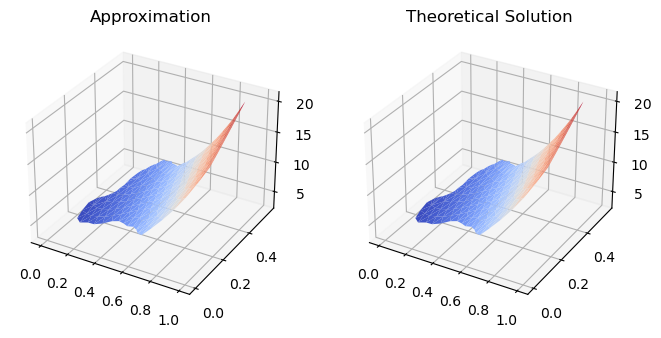

In [11]:
mini = u_ex.min()
maxi = u_ex.max()

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw = {"projection": "3d"}, figsize=(8, 4))
    
ax1.plot_trisurf(p[:,0], p[:,1], u_ap[:], triangles=tt, cmap=cm.coolwarm)
ax1.set_zlim([mini, maxi])
ax1.set_title('Approximation')
    
ax2.plot_trisurf(p[:,0], p[:,1], u_ex[:], triangles=tt, cmap=cm.coolwarm)
ax2.set_zlim([mini, maxi])
ax2.set_title('Theoretical Solution')

plt.show()